<a href="https://colab.research.google.com/github/qahaidari/Keras-classification-with-finetuned-vgg16-flask-deployment/blob/main/DogsvsCats_vgg16_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[VGG16](https://arxiv.org/abs/1409.1556) is a neural network classification model which was trained on [ImageNet](http://www.image-net.org/) dataset with 1000 different categories which already includes images of cats and dogs. In this example, a fine-tuning will be applied on VGG16 to classify images of cats and dogs. Therefore, we only have two classes. Because the model has already learned the features of cats and dogs, this fine-tuning will be minimal. [More on VGG16 and ImageNet](https://neurohive.io/en/popular-networks/vgg16/)

**Fine-tuning VGG16 model**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import urllib.request
import zipfile

In [ ]:
# change to base directory
os.chdir('/')

**Data Organization**

Below steps are for organizing the data. The dataset is downloaded from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats) website and unzipped. The train set contains 25000 images of cats and dogs. Here, I only use subsets of this train set and organize them into three train, validation and test directories. I used 1000 images for train, 200 for validation and 100 for test set. Note that the test samples that are organized in this way are already labeled. Unlabeled test samples are in another zip file named 'test1.zip'.

In [ ]:
# to load dataset from a URL and extract if needed
tf.keras.utils.get_file(
    'dogs-vs-cats', 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/3362/31148/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1612552827&Signature=R1Sgb2diN33vacHwLQkXI%2F3Gf8%2FlYlfMw8Picp6eUs9k7oflMsoxfIYbKr0Z0sMks8Oe9N0QWMQDjnHXisKkSmBuxIutoLHaNn9Ph9vYKb72AH88T3aE2fE5XTBgQ%2BN9KWbwJjeQ03%2BGI0VIFbV2Ev0Qb%2B79Ovowl8PaR092b7tSElFrPVKM5Vv0JA5U8l%2Fs6A5o5n76LHl4kwizvI%2FfsQivZ8StehKIu34ka7pnuRBRcwrC1KD116Mlri%2FNBD6C2YH0y%2FIcYFBPrWr9a0YxncewofXsSeGkWaLbeceCxaW86kyMT4EoQ6hwyNzJbxitmw8x7ULpmsgDdAPxyo%2FfGw%3D%3D&response-content-disposition=attachment%3B+filename%3Ddogs-vs-cats.zip', untar=False,
    cache_subdir='/content/drive/MyDrive/',
    extract=True
)

# delete dogs-vs-cats file which is already extracted
os.remove('/content/drive/MyDrive/dogs-vs-cats')

# to unzip train.zip file
with zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/')

# now delete train.zip file
os.remove('/content/drive/MyDrive/train.zip')

# rename train folder to dogs-vs-cats folder
os.rename('/content/drive/MyDrive/train', '/content/drive/MyDrive/dogs-vs-cats')

In [ ]:
# Organize data in dogs-vs-cats folder into train, valid, test directories
# note that test samples in this way are already labeled
os.chdir('/content/drive/MyDrive/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

# return to base directory
os.chdir('../../')

In [ ]:
# deleting multiple files matching a pattern
# remove remaining data from dogs-vs-cats folder
os.chdir('/content/drive/MyDrive/dogs-vs-cats')
for f in glob.glob('cat*'):
  os.remove(f)
for f in glob.glob('dog*'):
  os.remove(f)

os.chdir('/')

# moving test1.zip file into dogs-vs-cats folder for later use
shutil.move('/content/drive/MyDrive/test1.zip', '/content/drive/MyDrive/dogs-vs-cats')

# to unzip test1.zip file
with zipfile.ZipFile('/content/drive/MyDrive/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/dogs-vs-cats/')


# In Python you can use os.remove(), os.unlink(), pathlib.Path.unlink() to delete a single file.

# In Python you can use os.rmdir() and pathlib.Path.rmdir() to delete an empty directory 
# and shutil.rmtree() to delete a non-empty directory.

# rename test1 folder to unlabeled-test
os.rename('/content/drive/MyDrive/dogs-vs-cats/test1', '/content/drive/MyDrive/dogs-vs-cats/unlabeled-test')

# then delete the test1.zip file
os.remove('/content/drive/MyDrive/dogs-vs-cats/test1.zip')

**Data Processing**

Below are the necessary data processing steps to pass appropriate data to the network. 

In [3]:
# save train, valid and test data paths
train_path = '/content/drive/MyDrive/dogs-vs-cats/train'
valid_path = '/content/drive/MyDrive/dogs-vs-cats/valid'
test_path = '/content/drive/MyDrive/dogs-vs-cats/test'

In [4]:
# create batches of image data from train, valid and test sets
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

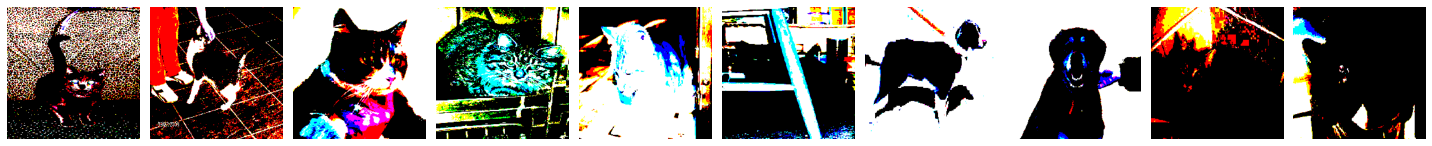

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [7]:
# visualize one batch of train images and labels
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

**Training on fine-tuned VGG16 model**

In [8]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

Since the type of our model is functional, we make a sequential model out of it by copying its layers, except the last layer, to a new variable.

In [11]:
# vgg16_model type is 'Model' from 'Functional' API. We copy its layers (except last layer) in a new model with type 
# 'Sequential'
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

Since our model is already trained on cats and dogs in the ImageNet dataset, we don't want to retrain the layers in our model. Therefore, all the layers in our model must be freezed. We only want to train our last layer becasue unlike VGG16 trained on ImageNet with 1000 categories, we only have two categories; cats and dogs.

In [12]:
for layer in model.layers:
    layer.trainable = False

In [13]:
model.add(Dense(units=2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=5,
          verbose=2
)

Epoch 1/5
100/100 - 340s - loss: 0.3560 - accuracy: 0.8370 - val_loss: 0.1166 - val_accuracy: 0.9500
Epoch 2/5
100/100 - 7s - loss: 0.0950 - accuracy: 0.9670 - val_loss: 0.0645 - val_accuracy: 0.9800
Epoch 3/5
100/100 - 7s - loss: 0.0549 - accuracy: 0.9850 - val_loss: 0.0515 - val_accuracy: 0.9900
Epoch 4/5
100/100 - 7s - loss: 0.0396 - accuracy: 0.9860 - val_loss: 0.0384 - val_accuracy: 0.9900
Epoch 5/5
100/100 - 7s - loss: 0.0274 - accuracy: 0.9930 - val_loss: 0.0294 - val_accuracy: 0.9950


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

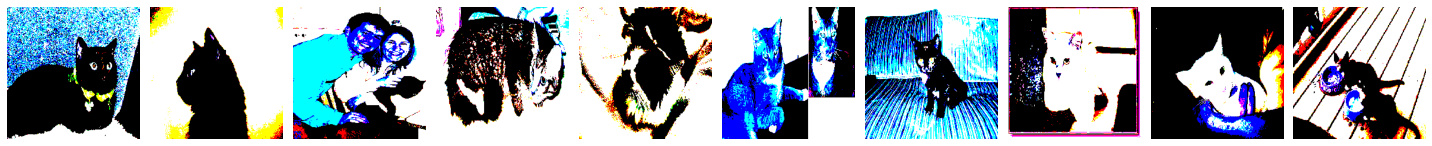

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [17]:
# visualize one batch of test images and labels
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [18]:
# do predictions on test data
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

Plot the confusion matrix. More information on [how to plot confusion matrices.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[47  3]
 [ 1 49]]


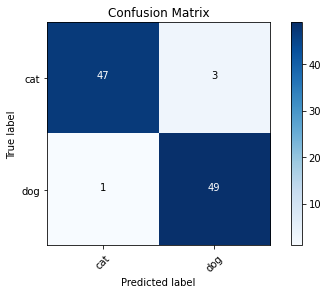

In [20]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Finally, we save our fine-tuned model in the form of h5 file.

In [21]:
model.save('/content/drive/MyDrive/dogs-vs-cats/VGG16_cats_and_dogs.h5')